In [1]:
import pandas as pd # Used for data manipulation and analysis
import matplotlib.pyplot as plt # Used for creating static, interactive, and animated visualizations
from sklearn.preprocessing import StandardScaler # Used to standardize features by removing the mean and scaling to unit variance
from sklearn.cluster import KMeans # Used for performing K-Means clustering, an unsupervised learning method
from sklearn.decomposition import PCA # Used for Principal Component Analysis, a technique for dimensionality reduction


In [2]:
df = pd.read_csv('pokemon.csv')

In [ ]:
# Define a list of the original feature column names from the raw dataset.
# QoD = Quality of Device, QoS = Quality of Service, QoA = Quality of Application
user_features = [
    "QoD_model", "QoD_os-version", "QoS_type",
    "QoA_VLCbitrate", "QoA_VLCframerate",
    "QoA_BUFFERINGcount", "QoA_VLCresolution"
]
# Create a user-level summary DataFrame by aggregating data for each 'user_id'.
# This transforms the data from a session/event level to a user level.
# 1. 'groupby("user_id")': Groups all rows belonging to the same user.
# 2. 'agg(...)': Calculates specific statistics for each user group.
#    - 'mean' and 'std' (standard deviation) for bitrate and framerate.
#    - 'mean' and 'max' for buffering count.
#    - 'mean' for MOS (Mean Opinion Score).
# 3. 'reset_index()': Converts the 'user_id' (which became the index after grouping) 
#    back into a regular column.
user_summary = df.groupby("user_id").agg({
    "QoA_VLCbitrate": ["mean", "std"],
    "QoA_VLCframerate": ["mean", "std"],
    "QoA_BUFFERINGcount": ["mean", "max"],
    "MOS": ["mean"],
}).reset_index()
# Flatten and rename the columns of the 'user_summary' DataFrame.
# The .agg() method creates hierarchical/multi-level columns (e.g., ('QoA_VLCbitrate', 'mean')).
# (e.g., 'bitrate_mean', 'bitrate_std') for easier data access.
user_summary.columns = ["user_id", "bitrate_mean", "bitrate_std", "framerate_mean", 
                        "framerate_std", "buffering_mean", "buffering_max", "mos_mean"]


In [ ]:
X = user_summary[["bitrate_mean", "bitrate_std", "framerate_mean", "buffering_mean"]]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Choose number of clusters 
kmeans = KMeans(n_clusters=3, random_state=42)
user_summary["cluster"] = kmeans.fit_predict(X_scaled)


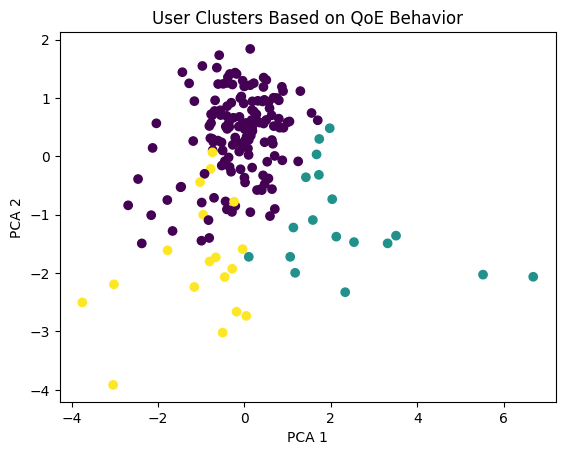

In [ ]:
# --- 1. Apply Principal Component Analysis (PCA) ---
pca = PCA(n_components=2) # Initialize the PCA object, requesting the top 2 principal components
pca_result = pca.fit_transform(X_scaled) # Fit PCA to the scaled features and transform them into the 2 new dimensions

plt.scatter(pca_result[:, 0], pca_result[:, 1], c=user_summary["cluster"], cmap="viridis")
plt.title("User Clusters Based on QoE Behavior")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.show()


Average Silhouette Score for k=3: 0.390


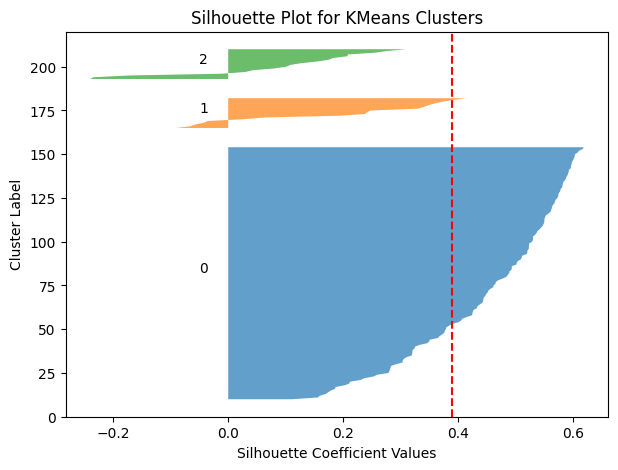

In [ ]:
from sklearn.metrics import silhouette_score, silhouette_samples 
# --- Cluster Validation: Silhouette Analysis ---
silhouette_avg = silhouette_score(X_scaled, user_summary["cluster"])
print(f"Average Silhouette Score for k=3: {silhouette_avg:.3f}")

# Compute silhouette scores for each sample
sample_silhouette_values = silhouette_samples(X_scaled, user_summary["cluster"])

# --- Silhouette Plot ---
fig, ax = plt.subplots(figsize=(7, 5))
y_lower = 10
n_clusters = 3

for i in range(n_clusters):
    cluster_silhouette_values = sample_silhouette_values[user_summary["cluster"] == i]
    cluster_silhouette_values.sort()
    cluster_size = cluster_silhouette_values.shape[0]
    y_upper = y_lower + cluster_size
    
    ax.fill_betweenx(
        range(y_lower, y_upper),
        0,
        cluster_silhouette_values,
        alpha=0.7
    )
    ax.text(-0.05, y_lower + 0.5 * cluster_size, str(i))
    y_lower = y_upper + 10  # space between clusters

ax.axvline(x=silhouette_avg, color="red", linestyle="--")
ax.set_title("Silhouette Plot for KMeans Clusters")
ax.set_xlabel("Silhouette Coefficient Values")
ax.set_ylabel("Cluster Label")
plt.show()

In [6]:
user_summary.groupby("cluster").mean()[["bitrate_mean", "framerate_mean", "buffering_mean", "mos_mean"]]

,bitrate_mean,framerate_mean,buffering_mean,mos_mean
cluster,,,,
0,501.509388,25.459499,1.323093,3.726582
1,691.825383,23.647507,1.276715,3.527823
2,497.782410,20.711194,2.350772,2.920922
